# Facial Recognition Lab

In [1]:
import numpy as np
from scipy import linalg as la
from os import walk
from scipy.ndimage import imread
from matplotlib import pyplot as plt
from random import sample

%matplotlib inline

## Problem 1
In this lab we will use the faces94 face image dataset found at http://cswww.essex.ac.uk/mv/allfaces/faces94.html This problem will make sure that you can load and display the images from the dataset.

1. Download the faces94 dataset from the link above and extract the files. You should now have a directory named “faces94” which contains photographs of 153 people, organized into folders by person.

2. The function getFaces() is given in the appendix. It constructs a set of face images by selecting exactly one face image for each person in the directory. It should return an array whose columns are flattened face images. Feel free to modify the given code. You may have to replace the parameter "./faces94" with the location of the directory faces94 on your machine.

In [2]:
# Problem 1
def getFaces(path="./faces94"):
    """Traverse the directory specified by 'path' and return an array containing one column vector per subdirectory.
    For the faces94 dataset, this gives an array with just one column for each face in the dataset.
    Each column corresponds to a flattened grayscale image.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in walk(path):
        for f in filenames:
            if f[-3:]=="jpg":          # only get jpg images
                 # Load the image, convert it to grayscale, and flatten it into vector.
                faces.append(imread(dirpath+"/"+f).mean(axis=2).ravel())
                break
    # Put all face vectors column-wise into a matrix.
    return np.transpose(faces)

Test this function to make sure it runs without errors. Check that the return value F is a 36000 x 153 array. The columns of this array are 153 flattened face images of 153 different people.

In [3]:
#Test Function
F = getFaces()

#Check that the return value is a 36000 by 153 array
print "type(F) == ", type(F)
print "F.shape ==", F.shape


type(F) ==  <type 'numpy.ndarray'>
F.shape == (36000, 153)


3) Use plt.imshow() to display one of the faces. The original image dimensions are 200 x 180. You may find it useful to write a helper function that accepts a flattened image and displays it.

In [4]:
def plot(img, w=200, h=180):
    """Helper function for plotting flattened images.
    -- note this was mostly provided.
    I did one tweak to make it grayscale"""
    plt.imshow(img.reshape((w,h)), cmap = 'gray') #cmap's default makes it look terrible
    plt.show()

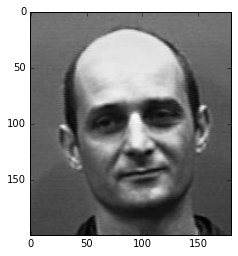

In [5]:
#Plot 1 random face to check to see if they actually are faces
#get 1 random index
number_faces = F.T.shape[0]
indices =  np.random.randint(number_faces, size=1)
mask = np.array([z in indices for z in range(number_faces)])
for x in F.T[mask]: #transpose so that rows are columns
    plot(x)

## Problem 2
The facial recognition method you will write in this lab will be structured as a class. An outline of the FacialRec class is provided in the appendix. You will write the methods of the class.

When initialized, the FacialRec object first loads the face images using getFaces and stores the result. The next step is to compute the mean face.

The mean is given by

$$ \boldsymbol{\mu} = \frac{1}{k} \sum_{i=1}^{k}\boldsymbol{f_i} $$

Where $\boldsymbol{f_i}$ is the _ith_ face vector, and k is the number of face vectors we have.

#### Problem Statement

1. In your class definition, implement the method FacialRec.initMeanImage(). Compute the mean face and store it as self.mu. This can be done in one line of code using NumPy.

2. Display the mean face.

## Problem 3

We define the *ith* mean-shifted vector $\boldsymbol{\overline{f_i}}$ as follows.

$$\boldsymbol{\overline{f_i}} = \boldsymbol{f_i} - \boldsymbol{\mu} $$

We then define a matrix $\overline{F}$ which has the mean shifted vectors as columns.

$$\overline{F} = \begin{bmatrix}\boldsymbol{\overline{f_1}} &&\boldsymbol{\overline{f_2}} &&\ldots &&\boldsymbol{\overline{f_k}} \end{bmatrix}$$

#### Problem Statement

1. In your class definition, implement the method FacialRec.initDifferences(). Compute $\overline{F}$ and store it as self.Fbar. This can be done in one line using array broadcasting.

2. Display one of the mean-shifted faces.

## Problem 4
Ok, we actually have to recognize faces, right?

The way we'd like to do that is just compare pixel by pixel.

But that is a computationally expensive operation.  In our case there are 36000 pixels per picture  Instead, we can try to find an orthonormal basis for the faces, which will involve only a few "eigenfaces".  The singular value decomposition of $\overline{F}$ produces an excellent basis, and vectors are ordered to minimize error, so we can use some of the largest vectors to approximate the new face, and then see which face is closest.

#### Problem Statement
1. In your class definition, implement the method FacialRec.initEigenfaces(). Compute the SVD (scipy.linalg.svd() is a good implementation to use) and store the array U containing the eigenfaces as its columns. Because we will only use the first few columns of U, specify the keyword parameter full_matrices=False to compute only the compact SVD.

2. Plot the first eigenface (i.e. the first column of U).

## Problem 5

If we let $U_s$ represent the matrix formed from the first s columns of $U$ from the singular value decomposition of $\overline{F}$, then the matrix

$$P_s = U_s U_s^T $$

will project a face vecotor onto the span of the first s eigenfaces.  Multiplication by $U_s^T$ will give the coordinate vector of the face in terms of the basis of the first s eigenfaces.

#### Problem Statement
1. Implement the method FacialRec.project() in your class definition. This should accept a flattened image or an array with flattened images as its columns. It should also accept a value for s. The function should project the image or images into the appropriate s-dimensional subspace and change basis, then return the result.

2. Let *face* be the first mean-shifted face (the first column of facialRec.Fbar). Do the following:

    a. Project *face* so that it is represented in terms of the first 19 eigenfaces.
    
    b. Change basis again back to the standard basis on Rmn.
    
    c. Add back the mean face facialRec.mu.
    
    d. Plot the resulting image.

## Problem 6
Now comes the actual facial recognition.

Given an input face $\boldsymbol{g}$, we want to find the face $\boldsymbol{f}_i$ that most closely resembles it.

It will be easier to deal with $\boldsymbol{\overline{g}}$ and $\boldsymbol{\overline{f}}_i$, the mean-shifted faces.

The vectors $\boldsymbol{\overline{g}}$ and $\boldsymbol{\overline{f}}_i$ will still have 36000 pixels.  So, it makes more sense to choose a number $s \in \mathbb{N}$ and project both $\boldsymbol{\overline{g}}$ and $\boldsymbol{\overline{f}}_i$ onto the space spanned by the first $s$ eigenfaces.  If we let $\hat{\boldsymbol{g}}$ and 
$\hat{\boldsymbol{f}_i}$ represent the coordinate vectors of $\boldsymbol{\overline{g}}$ and $\boldsymbol{\overline{f}}_i$ in the space spanned by the first $s$ eigenvectors, then we know by problem 5 that:

$$\hat{\boldsymbol{g}} = U_s^T \boldsymbol{\overline{g}}$$ 
$$\hat{\boldsymbol{f}}_i = U_s^T \boldsymbol{\overline{f}}_i$$

If we let $i$ vary over all the different eigenfaces, then the best guess for the face would be the $j$th eigenface where

$$j =  argmin_i \lvert \lvert \hat{\boldsymbol{f}}_i - \hat{\boldsymbol{g}} \lvert \lvert _2$$

Where $\vert \vert \cdot \vert \vert _2$ is the usual euclidean norm

#### Problem Statement
1. Implement the method FacialRec.findNearest() as follows. The functions np.linalg.norm() and np.argmin() will be useful for the last line. When using np.linalg.norm, make sure you indicate the correct axis.
2. Test your facial recognition system on faces selected randomly from the faces94 dataset. The function sampleFaces(n_tests, path) at the end of this lab will build an array of n_tests random faces from the faces94 dataset. Plot the random face beside the face returned by your facial recognition code to see if your system is accurately recognizing faces.

In [6]:
# Problems 2, 3, 4, 5
class FacialRec:
    """
    Attributes:
        F -- The 2-dimensional array of faces.  The columns are the raveled matrices of the pictures.
        mu -- The mean face
        Fbar -- The matrix of mean-shifted face vectors
        U -- The matrix that holds the "eigenfaces" of the dataset
    """
    def __init__(self,path):
        """
        Input -- path --the directory to the folder of faces as a string
        
        Loads the face array and stores it as attribute F
        Calculates the mean face and stores it as mu.
        """
        #load the face images
        self.F = self.initFaces(path)
        
        #compute the mean face
        self.mu = self.initMeanImage()
        
        #compute the matrix of mean-shifted matrices
        self.Fbar = self.initDifferences()
        
        #find the eigenfaces
        self.U = self.initEigenfaces()
        
    def initFaces(self, path):
        """
        Initializes the face arrays based on the initializing directory parameter 'path'
        """
        #use getFaces to load the face images
        return getFaces(path)

    def initMeanImage(self):
        """
        Calculates the mean face (mu)
        """
        #Hey, watch me do this in one line using numpy methods.
        # 1/k sum(x_i) from i=1 to i=k  is the mean of the set {x_i}_{i=1}^{k}
        return self.F.mean(axis = 1) #mean of axis 1 returns the average of the columns
    
    def initDifferences(self):
        """
        Calculates the mean-shifted vectors
        """
        # Fbar = [f_1 - mu, f_2 - mu, ..., f_k - mu] -- definition of Fbar
        #      = [f_1, f_2, ..., f_k] - mu           -- array broadcasting works this way in numpy
        #      = F - mu                              -- definition of F
        #      = self.F - self.mu                    -- way that these variables are accessed
        #reshape mu to be a column vector, so that way it will broadcast across the columns of F
        return self.F - self.mu.reshape((-1,1))
        
    def initEigenfaces(self):
        """
        Determines the eigenfaces (U) using the Singular Value Decomposition
        """
        #U, s, Vh = la.svd(self.F)
        #return U
        return la.svd(self.F, full_matrices = False)[0]
        #Look at me with all these one liners.
        #They seriously should just have the constructor do these things.
        
    def project(self, A, s=38):
        """
        Inputs  A -- an array with the faces we want to project as columns
                s -- the number of eigenfaces we will use in the projection
                
        Returns -- A matrix with the coordinate vectors of the projection of each column
                    of A in terms of the first s columns of self.U
        """
        #Multiply A by U^T.  This will change it to be the coordinate vector of the face in the first s eigenfaces
        return np.dot((self.U[:,:s]).T , A)
    
    def findNearest(self, image, s=38):
        """
        Inputs
            image -- a 36000-element array, which is a flattened, grayscale, 200 by 180 picture of a face.
            s     -- the number of eigenfaces we will project onto
        
        Output:
            The INDEX of the best approximating face
        """
        #Mean-shift the image
        gbar  = image - self.mu
        
        #Project the mean-shifted image onto the space of the first 's' eigenfaces
        ghat  = self.project(gbar, s)
        
        #Project the whole dataset of faces onto the space of the first 's' eigenfaces to find all the f-hats
        Fhat = self.project(self.Fbar, s)
        
        #Retrun the index that minimizes ||fhat - ghat||_2
        #
        #Fhat has the faces as columns, so we need to shape ghat as a column
        #Fhat - ghat.reshape(-1,1)
        #
        #We need to calculate the norm along the columns of this result.  So, la.norm needs the keyword axis set to 0
        #la.norm(Fhat - ghat.reshape(-1,1), axis=0)
        #
        #We then need the column that has the smallest norm.  la.norm(Fhat - ghat.reshape(-1,1), axis=0) will return the
        #norms of the columns as an array.  So, we just need to use np.argmin() to find the index of that smallest norm
        return np.argmin(  la.norm( Fhat- (ghat.reshape((-1,1))) , axis=0 )  )

### Problem 2 -- Display the Mean Face

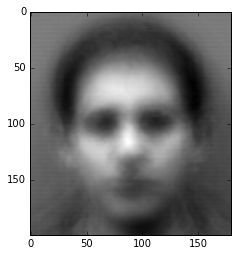

In [7]:
#Make a FacialRec instance
my_faces = FacialRec("./faces94")

#Display the mean face
plot(my_faces.mu)

### Problem 3 -- Display a Mean-Shifted Face

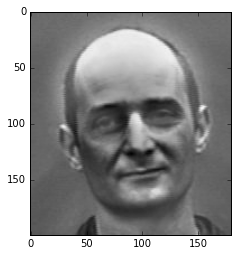

In [8]:
#Heck, why not plot the same 8 faces I had before?
#Note to self, person at index 12 is black -- so their image is an outlier, and hence illustrates really well
#how different a  mean-shifted face can end up being.
for x in my_faces.Fbar.T[mask]:
    plot(x)

### Problem 4 Testing -- Plot the First Eigenface

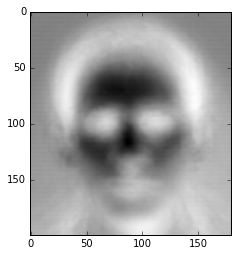

In [9]:
#first eigenface is first column of U
#first column of U is U[:,0] -- 0 index
plot(my_faces.U[:,0])
#I'm gonna check out the other two as well
#plot(my_faces.U[:,1])
#plot(my_faces.U[:,2])

In [10]:
#Wow.  If that's not freaky I don't know what is.  I think I'll go as an eigenface for Halloween.

### Problem 5 -- Project the First Face in the Dataset, Then Plot the Projection
Let *face* be the first mean-shifted face (the first column of facialRec.Fbar). Do the following:

a) Project *face* so that it is represented in terms of the first 19 eigenfaces.

b) Change basis again back to the standard basis on $\mathbb{R}^{m \cdot n}$.

c) Add back the mean face facialRec.mu.

d) Plot the resulting image.

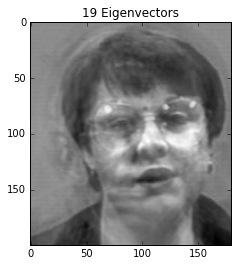

In [11]:
#Let face be the first mean-shifted face
face = my_faces.Fbar[:,0]

#project face so that it is represented in terms of the first 19 eigenfaces
coordinate_vector = my_faces.project(face, s=19)

#change basis again back to the standard basis on Rmn
projected_face = np.dot(my_faces.U[:,:19], coordinate_vector)

#add back the mean face
projected_face += my_faces.mu

#plot the resulting image
plt.title("19 Eigenvectors")
plot(projected_face)


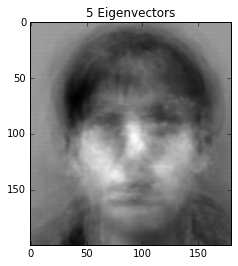

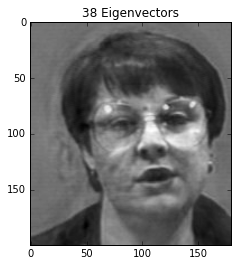

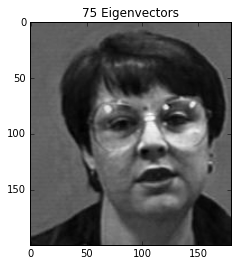

In [12]:
#Ok, that's lame.  Let's just try couple different number of eigenvectors
for s_0 in [5,38, 75]:
    plt.title("%d Eigenvectors"%s_0)
    coordinate_vector = my_faces.project(face, s_0)

    projected_face = np.dot(my_faces.U[:,:s_0], coordinate_vector) + my_faces.mu

    plot(projected_face)

### Problem 6 -- Test your facial recognition system on faces selected randomly from the faces94 dataset. 
The function sampleFaces(n_tests, path) at the end of this lab will build an array of n_tests random faces from the faces94 dataset. Plot the random face beside the face returned by your facial recognition code to see if your system is accurately recognizing faces


In [13]:
#This is the provided sampleFaces function
def sampleFaces(n_tests,path = "./faces94"):
    """Return an array containing a sample of n_tests images contained
    in the path as flattened images in the columns of the output.
    """
    files = []
    for (dirpath, dirnames, filenames) in walk(path):
        for f in filenames:
            if f[-3:]=="jpg": # only get jpg images
                files.append(dirpath+"/"+f)
                
    #Get a sample of the images
    test_files = sample(files, n_tests)
    #Flatten and average the pixel values
    images = np.array([imread(f).mean(axis=2).ravel() for f in test_files]).T
    return images

#Get a sample of 5 faces
Sample_Faces = sampleFaces(5)

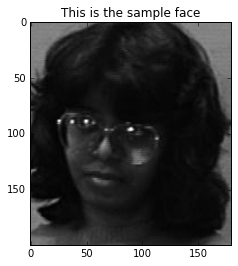

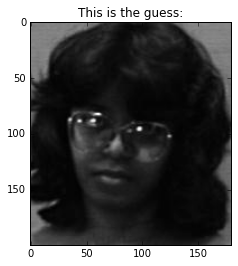

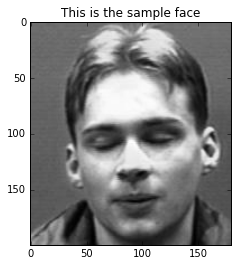

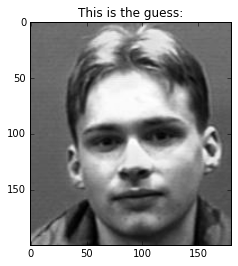

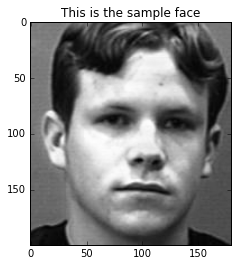

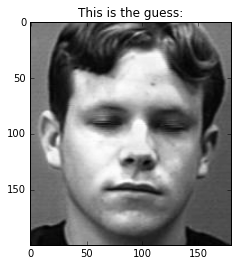

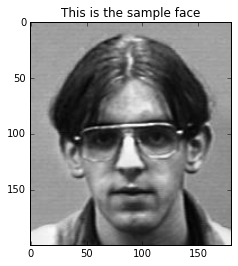

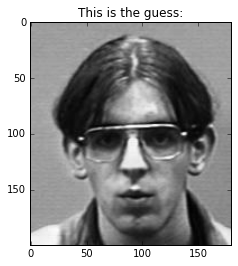

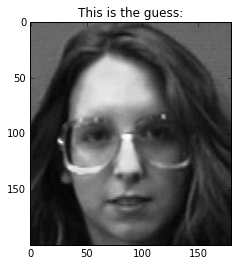

In [14]:
#go through each face in the sample
for sample_face in Sample_Faces.T:#2-dimensional arrays are iterated through rows, and we need the columns
    
    #get the guess index
    j = my_faces.findNearest(sample_face)
    
    #use the index to get the actual guess
    guess = my_faces.F[:,j]
    
    #print of the face
    plt.title("This is the sample face")
    plot(sample_face)
    
    #print the guess
    plt.title("This is the guess:")
    plot(guess)